<a href="https://colab.research.google.com/github/MdRiyadulHasan/Classification_Image_Using_Cifar_10_Dataset/blob/main/skin_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import itertools

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras.utils.vis_utils import plot_model

In [71]:
df = pd.read_csv('/gdrive/MyDrive/Data Folder/base_skin_dir/HAM10000_metadata.csv')
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [73]:
df.shape

(10015, 7)

In [74]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [75]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

<ipython-input-75-951484299878>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(int(df['age'].mean()),inplace=True)


In [76]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [77]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
# base_skin_dir = '/content/HAM10000_metadata.csv'

In [78]:
import os
from glob import glob

# Define the base directories for part 1 and part 2
base_skin_dir_1 = '/gdrive/MyDrive/Data Folder/HAM10000_images_part_1'
base_skin_dir_2 = '/gdrive/MyDrive/Data Folder/HAM10000_images_part_2'

# Collect images from both directories
image_paths_part_1 = glob(os.path.join(base_skin_dir_1, '*.jpg'))
image_paths_part_2 = glob(os.path.join(base_skin_dir_2, '*.jpg'))

# Merging the images from both folders into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in image_paths_part_1 + image_paths_part_2}

# Print the first few entries to verify
print(list(imageid_path_dict.items())[:5])


[('ISIC_0028270', '/gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0028270.jpg'), ('ISIC_0028326', '/gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0028326.jpg'), ('ISIC_0028311', '/gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0028311.jpg'), ('ISIC_0028281', '/gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0028281.jpg'), ('ISIC_0028272', '/gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0028272.jpg')]


In [79]:
skin_df = pd.read_csv('/gdrive/MyDrive/Data Folder/base_skin_dir/HAM10000_metadata.csv')

In [80]:
# skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [81]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                                  path  \
0  /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0027419.jpg   
1  /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0025030.jpg   
2  /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0026769.jpg   
3  /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0025661.jpg   
4  /gdrive/MyDrive/Data Folder/HAM10000_images_part_2/ISIC_0031633.jpg   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [82]:
import pandas as pd

# Set the option to display the full length of strings in a DataFrame
pd.set_option('display.max_colwidth', None)

# Now, when you display the DataFrame, it will show the full path
print(skin_df[['path']])


                                                                      path
0      /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0027419.jpg
1      /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0025030.jpg
2      /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0026769.jpg
3      /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0025661.jpg
4      /gdrive/MyDrive/Data Folder/HAM10000_images_part_2/ISIC_0031633.jpg
...                                                                    ...
10010  /gdrive/MyDrive/Data Folder/HAM10000_images_part_2/ISIC_0033084.jpg
10011  /gdrive/MyDrive/Data Folder/HAM10000_images_part_2/ISIC_0033550.jpg
10012  /gdrive/MyDrive/Data Folder/HAM10000_images_part_2/ISIC_0033536.jpg
10013  /gdrive/MyDrive/Data Folder/HAM10000_images_part_2/ISIC_0032854.jpg
10014  /gdrive/MyDrive/Data Folder/HAM10000_images_part_2/ISIC_0032258.jpg

[10015 rows x 1 columns]


<Axes: xlabel='cell_type'>

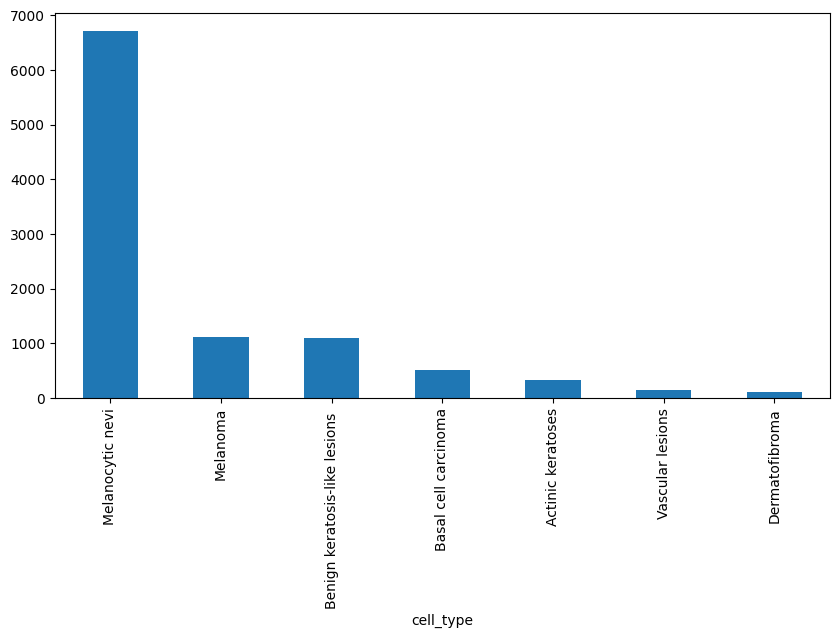

In [83]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<Axes: xlabel='dx_type'>

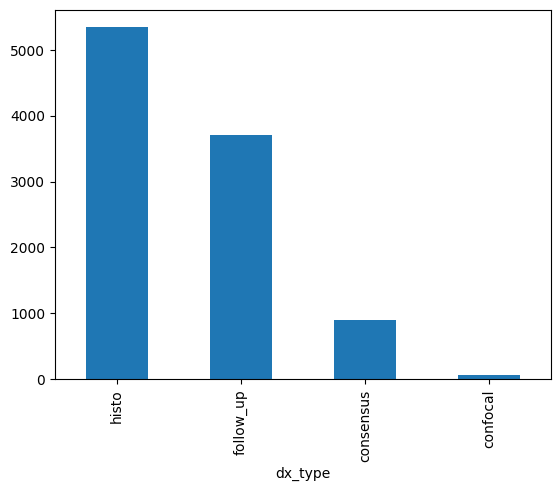

In [84]:
skin_df['dx_type'].value_counts().plot(kind='bar')

In [85]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [86]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                                  path  \
0  /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0027419.jpg   
1  /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0025030.jpg   
2  /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0026769.jpg   
3  /gdrive/MyDrive/Data Folder/HAM10000_images_part_1/ISIC_0025661.jpg   
4  /gdrive/MyDrive/Data Folder/HAM10000_images_part_2/ISIC_0031633.jpg   

                        cell_type  cell_type_idx  \
0  Benign keratosis-like lesions               2   
1  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
3  Benign keratosis-like lesions               2   
4  Benign keratosis-like lesions               2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

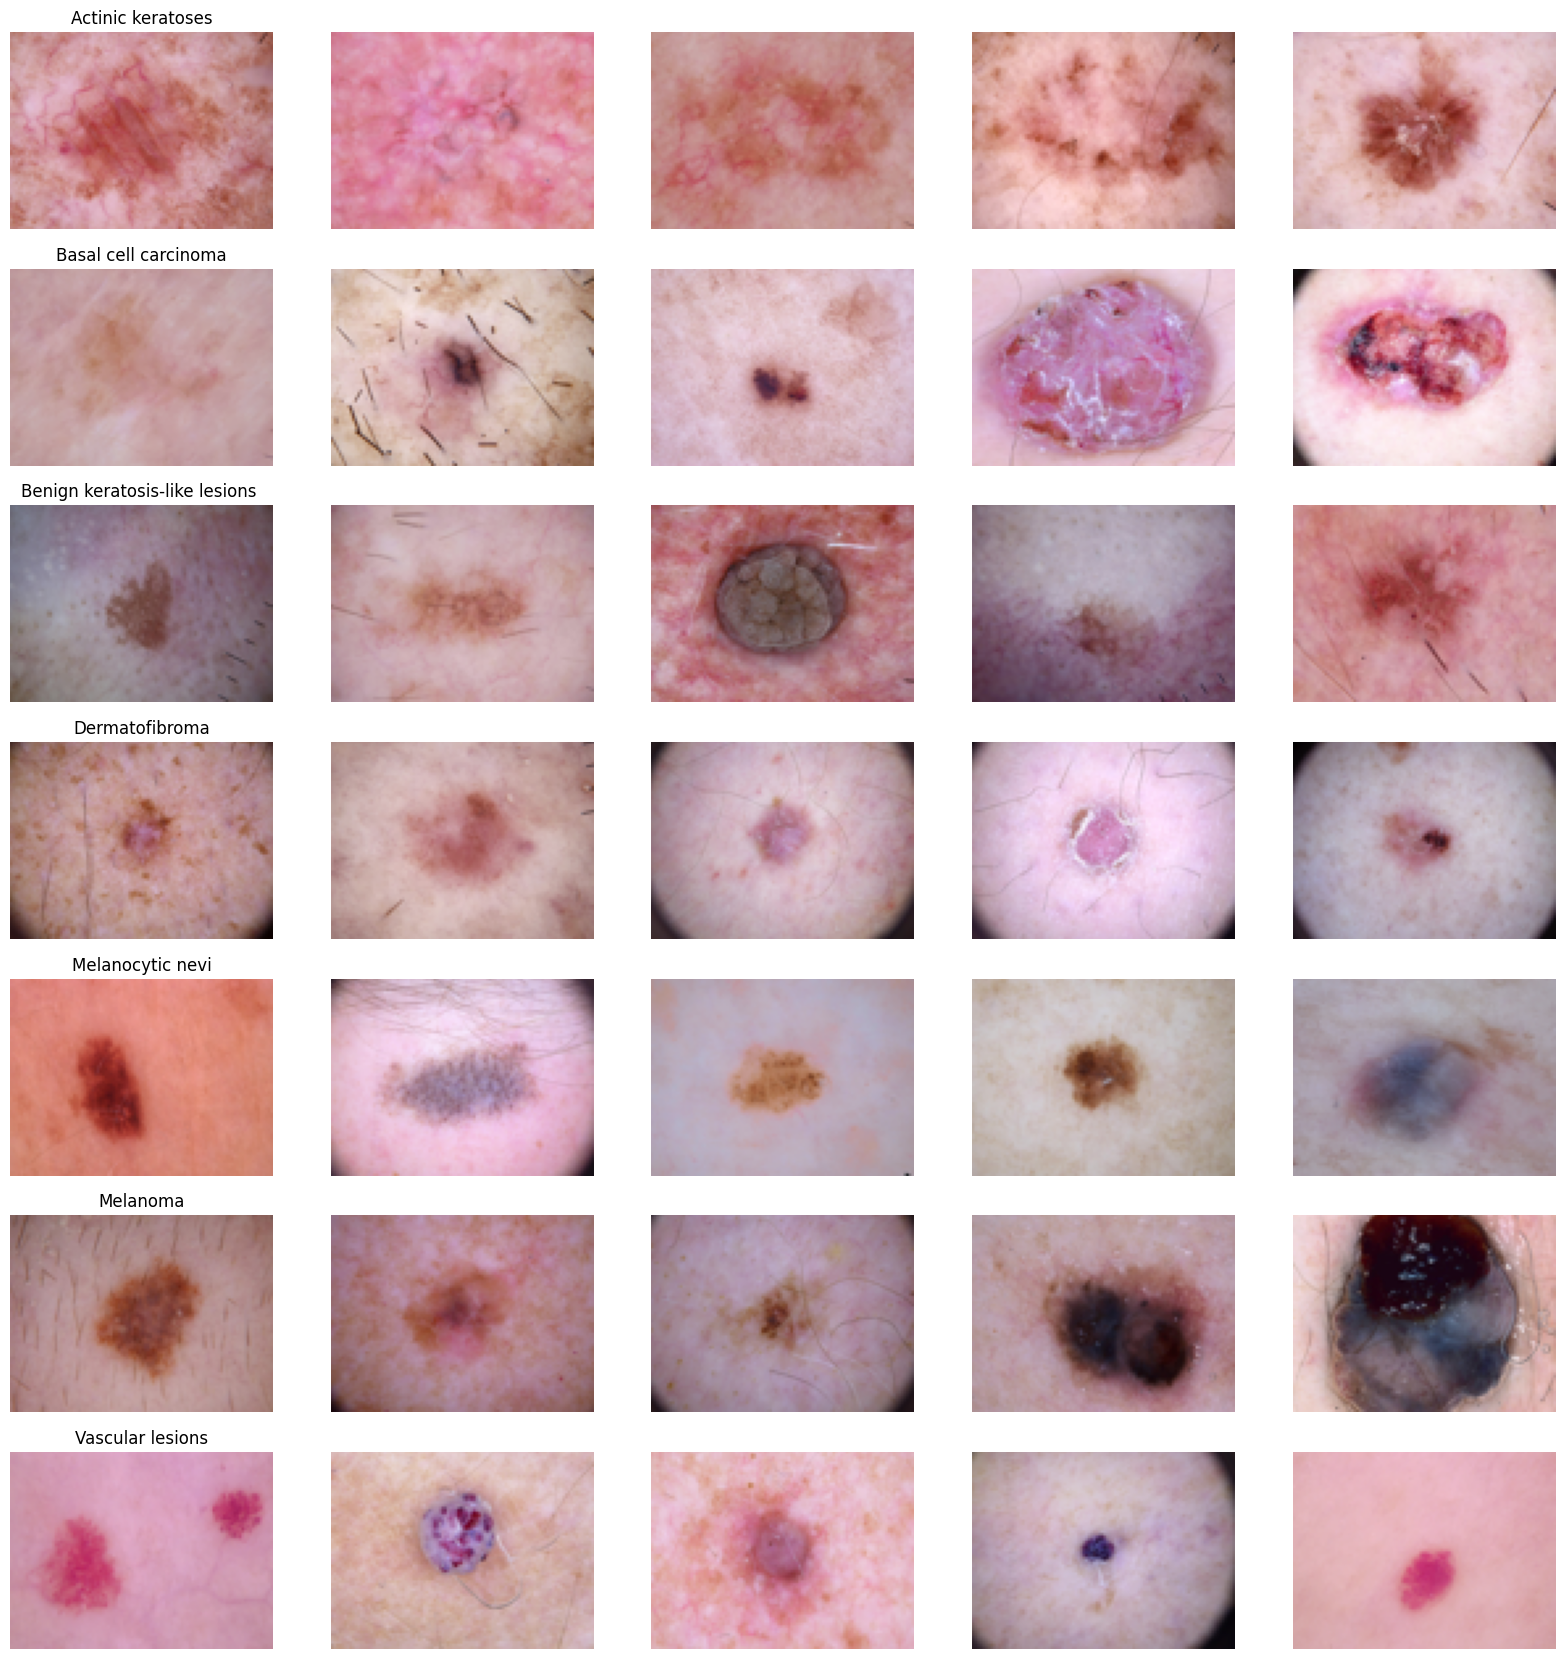

In [87]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

<Axes: title={'center': 'CELL TYPE'}, xlabel='cell_type', ylabel='Count'>

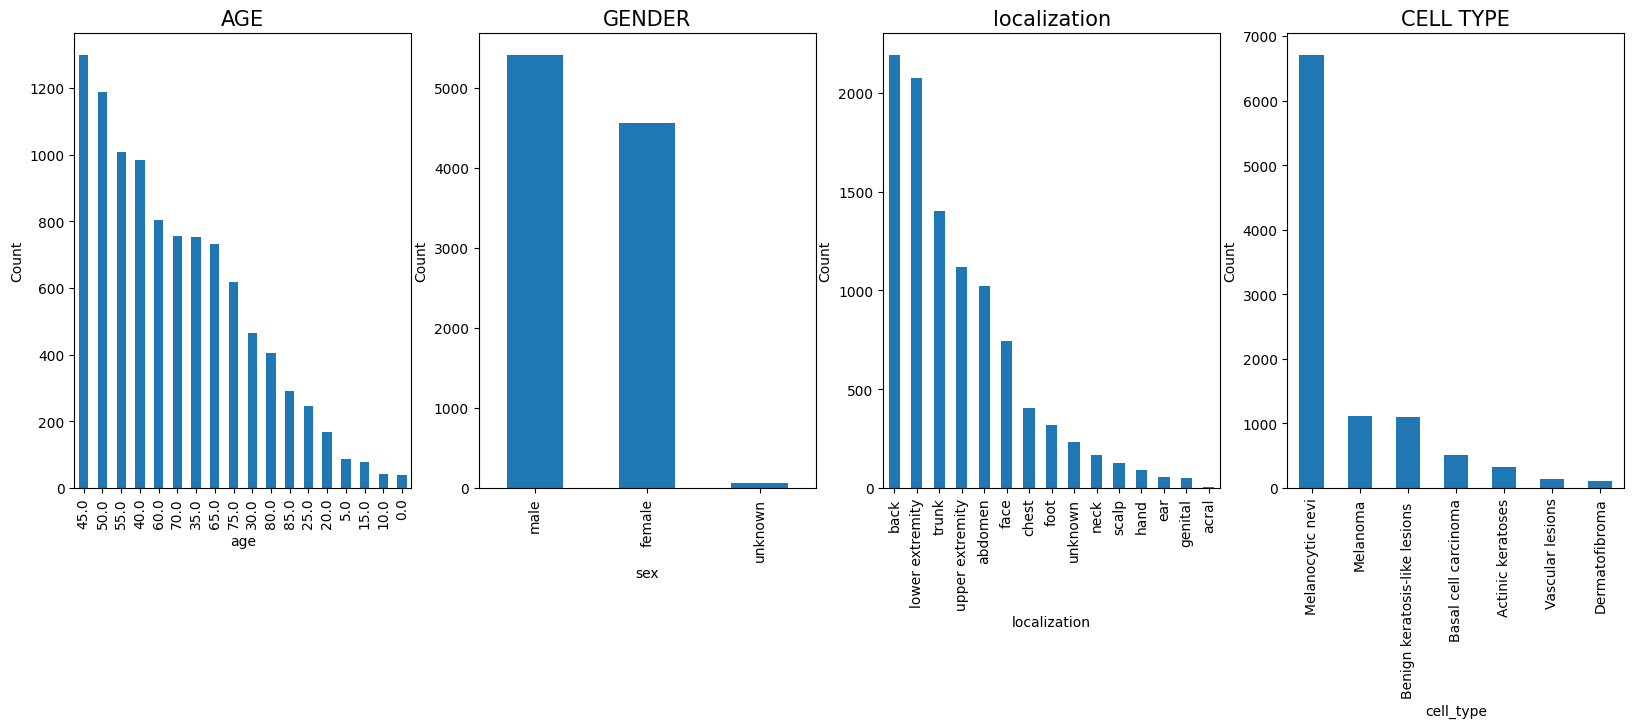

In [88]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
skin_df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
skin_df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
skin_df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
skin_df['cell_type'].value_counts().plot.bar()

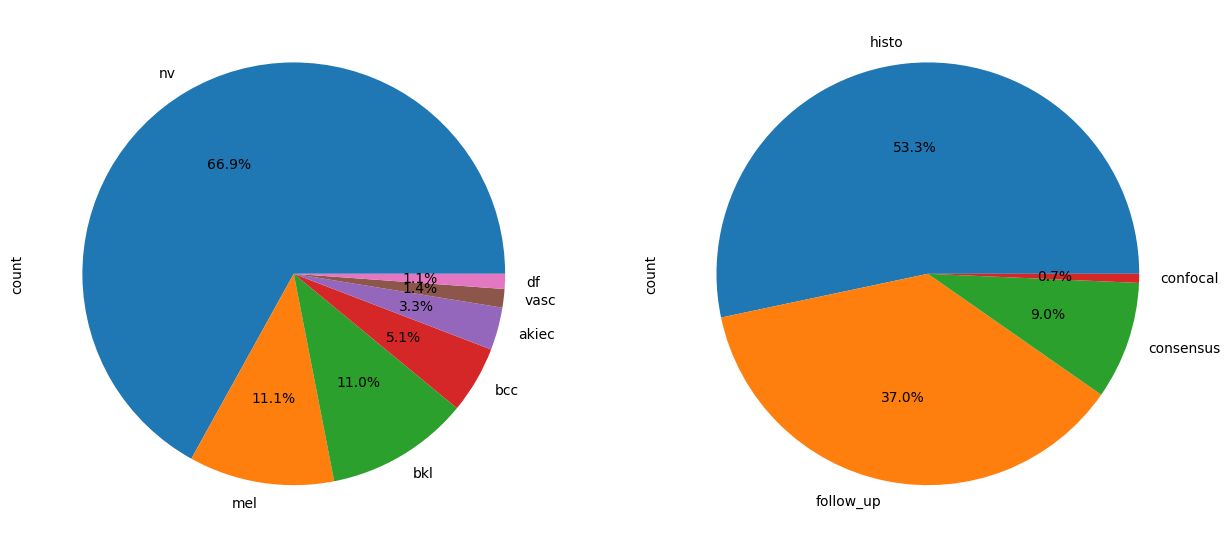

In [89]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
skin_df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
skin_df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

CNN Model


In [90]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [91]:
# Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*3 -> Flatten -> Dense*2
#Dropout -> Out
input_shape = (100, 75, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 100, 75, 32)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 100, 75, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 50, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 50, 37, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 50, 37, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 25, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 25, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 25, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 25, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 9, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 9, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6912)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       1,769,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,887,591 (7.20 MB)

 Trainable params: 1,887,591 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# Define the optimizer
from keras.optimizers import Adam

# Define the optimizer
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

# optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [93]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [94]:
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [96]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [99]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/gdrive/MyDrive/Data Folder/models/my_model_pre_trained.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')



In [102]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Vascular lesions', b'Benign keratosis-like lesions ',
       b'Actinic keratoses', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7511,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 0, 0], dtype=int32)>)

In [103]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [104]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [113]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 75, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 75, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 75, 3))
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [114]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=1, mode='auto')

In [115]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_validate shape: {x_validate.shape}")
print(f"y_validate shape: {y_validate.shape}")


x_train shape: (6083, 100, 75, 3)
y_train shape: (6083, 7)
x_validate shape: (676, 100, 75, 3)
y_validate shape: (676, 7)


In [116]:
import numpy as np

x_train = np.array(x_train)
y_train = np.array(y_train)
x_validate = np.array(x_validate)
y_validate = np.array(y_validate)


In [120]:

batch_size = 16
# Use `next()` function instead of `.next()`
print(f"Generator output shape: {next(datagen.flow(x_train, y_train, batch_size=batch_size))[0].shape}")
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Generator output shape: (16, 100, 75, 3)


In [ ]:
# Fit the model
epochs = 60
batch_size = 16
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[checkpoint,early_stopping])



Epoch 1/60
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.6566 - loss: 1.1540
Epoch 1: val_accuracy improved from -inf to 0.64497, saving model to /gdrive/MyDrive/Data Folder/models/my_model_pre_trained.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 243s 628ms/step - accuracy: 0.6566 - loss: 1.1537 - val_accuracy: 0.6450 - val_loss: 1.0209
Epoch 2/60
  1/380 ━━━━━━━━━━━━━━━━━━━━ 3:11 505ms/step - accuracy: 0.5000 - loss: 1.1299

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.64497
380/380 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5000 - loss: 1.1299 - val_accuracy: 0.6450 - val_loss: 1.0385
Epoch 3/60
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.6763 - loss: 0.9389
Epoch 3: val_accuracy did not improve from 0.64497
380/380 ━━━━━━━━━━━━━━━━━━━━ 236s 619ms/step - accuracy: 0.6763 - loss: 0.9389 - val_accuracy: 0.6435 - val_loss: 1.0204
Epoch 4/60
  1/380 ━━━━━━━━━━━━━━━━━━━━ 5:00 793ms/step - accuracy: 0.7500 - loss: 0.7628
Epoch 4: val_accuracy did not improve from 0.64497
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7500 - loss: 0.7628 - val_accuracy: 0.6435 - val_loss: 0.9957
Epoch 5/60
339/380 ━━━━━━━━━━━━━━━━━━━━ 24s 597ms/step - accuracy: 0.6759 - loss: 0.9007

In [ ]:
from tensorflow.keras.metrics import Recall
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=1, mode='auto')  # In early_stopping (patience=7) for customize model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(train_data,
                     steps_per_epoch=steps_per_epoch,
                     validation_data=validation_data,
                     validation_steps=validation_steps,
                     epochs=epochs,
                     callbacks=[checkpoint,early_stopping],
                     verbose=1)